<a href="https://colab.research.google.com/github/mctrinh/ggColab/blob/main/starting_colab_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Colab to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls "/content/gdrive/My Drive/"   # reach the drive at anytime
!cd                               # bash commands start with !
                                  # !python script.py to run a python file
                                  # !git clone <REPOSITORY URL> to clone a repository

# Specifications

## Check CPU and RAM spec

In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo

## Check GPU spec

In [ ]:
import tensorflow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# Import resources

In [ ]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
# print(PIL.PILLOW_VERSION)

from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
# !pip3 install torch torchvision
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

# install library: !pip install <LIBRARY> or !apt-get install <LIBRARY>
# !pip install -q keras
import keras

# Upload and download files

In [ ]:
# upload files from computer
from google.colab import files
files.upload()

In [ ]:
# download files and run
from google.colab import files
files.download('/content/filename.pdf')

In [ ]:
# download and unzip a shared zip file link
# !wget <ENTER URL>
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

# GPUs in Colab

The default hardware in Colab is CPU.

Go to *Runtime/Change runtime type* or *Edit/Notebook Settings* to enable GPU/TPU.

When a GPU is connected, a maximum of 12 hours at a time on the Cloud Machine is given.

**To check if GPU is enable:**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Observe TensorFlow speedup on GPU relative to CPU:**


In [ ]:
%tensorflow_version 2.x 
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use GPU. Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu. \n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# Let's run each op(eration) once to warm up; refer: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op(eration) several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6912122860003365
GPU (s):
0.04948854800022673
GPU speedup over CPU: 74x


# TPUs in Colab

Train a model to classify the images of flowers on Google's lightning-fast Cloud TPUs.

The model will take as input a photo of a flower and return wether it is a daisy, dandelion, rose, sunflower, or tulip.

We use the Keras framework, new to TPUs in TF 2.1.0. Adapted from [this notebook](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb) by [Martin Gorner](https://twitter.com/martin_gorner).

Copyright 2019-2020 Google LLC. Licensed under the Apache License, Version 2.0 (the "License")

To enable TPUs, do similar way with GPUs.

**To check of TPU is enable:**

In [ ]:
%tensorflow_version 2.x 
import tensorflow as tf 
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the instruction to enable GPUs/TPUs!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt

## Input data

The input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs, and to avoid bottlenecking on data transfer, the input data is stored in TFRecord files, 230 images per file.

Below, the `tf.data.experimental.AUTOTUNE` is heavily used to optimize different parts of input loading.

All these techniques are a bit overkill the (small) dataset, but demonstrate best practices for using TPUs.

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

def parse_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
      "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
      "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0  # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

# Create some additional training image by randomly flipping and 
# increasing/decreasing the saturation of images in the training set.
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

# Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO)

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

Let's take a peek at the training dataset we've created:

In [ ]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)

# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

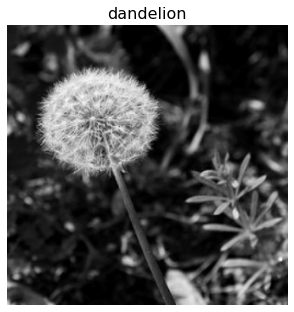

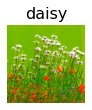

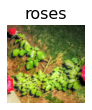

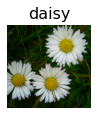

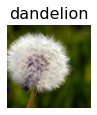

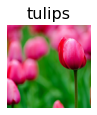

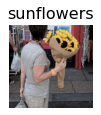

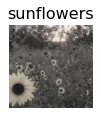

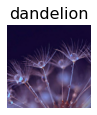

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1)  # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

## Model

To get maximum accuracy, a pretrained image recognition model (named [Xception](https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)) is leveraged.

The ImageNet-specific top layers (`include_top=false`) are dropped, and a max pooling and a softmax layer are added to predict our 5 classes. 

In [ ]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
      pretrained_model, tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

with tpu_strategy.scope():  # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()


83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 11, 11, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


## Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.

In [ ]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


Calculate and show a learning rate schedule. Start with a fairly low rate, as a pre-trained model (with all the fine work put into training it) is used. 

Learning rate per epoch:


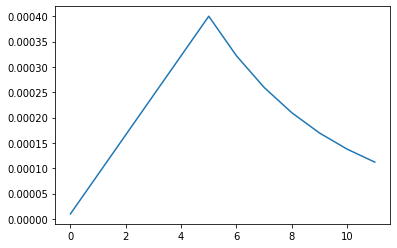

In [ ]:
EPOCHS = 12

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data, later epochs should complete in ~5s.

Note: XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.

In [ ]:
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/12
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


23/23 [==============================] - 69s 880ms/step - loss: 1.4998 - accuracy: 0.3801 - val_loss: 1.3898 - val_accuracy: 0.5735 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/12
23/23 [==============================] - 9s 375ms/step - loss: 0.7795 - accuracy: 0.8003 - val_loss: 0.3657 - val_accuracy: 0.8941 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/12
23/23 [==============================] - 9s 393ms/step - loss: 0.2583 - accuracy: 0.9239 - val_loss: 0.1566 - val_accuracy: 0.9500 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/12
23/23 [==============================] - 9s 375ms/step - loss: 0.1404 - accuracy: 0.9552 - val_loss: 0.1273 - val_accuracy: 0.9603 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/12
23/23 [==============================] - 9s 374ms/step - loss: 0.0716 - accuracy

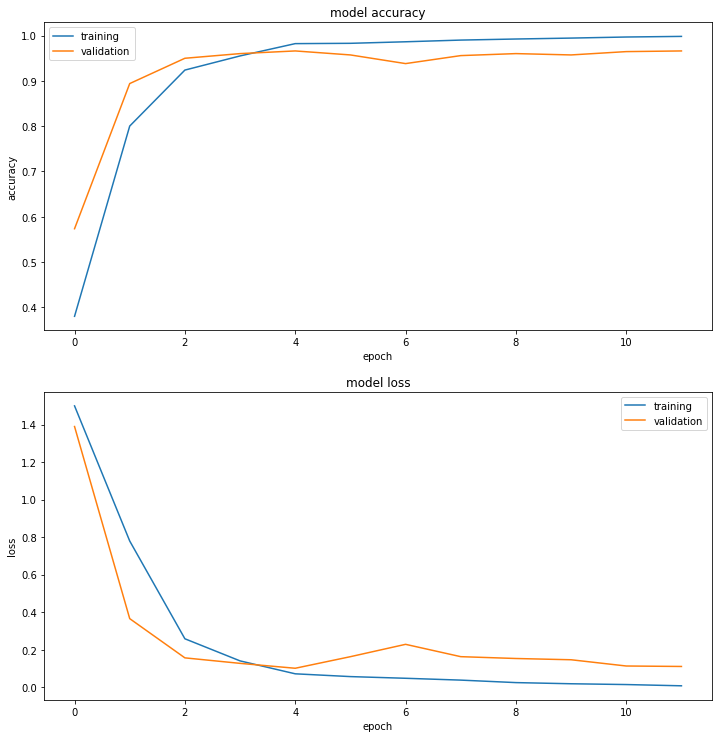

In [ ]:
from IPython.core.pylabtools import figsize
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

## Prediction

Let's look at some our model's predictions next to the original images. We'll show 9 images from the validation set.

In [ ]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

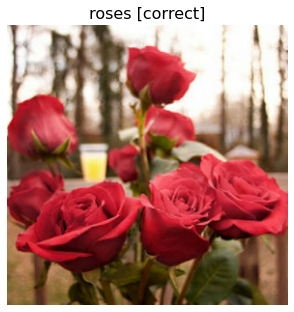

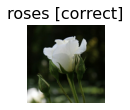

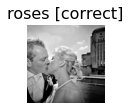

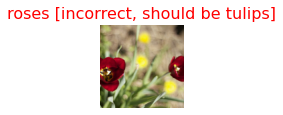

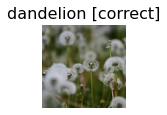

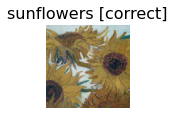

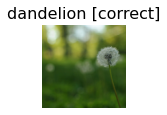

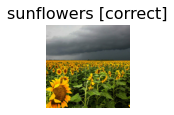

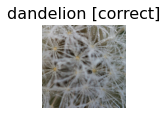

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

## Save and re-loading our trained model



In [ ]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


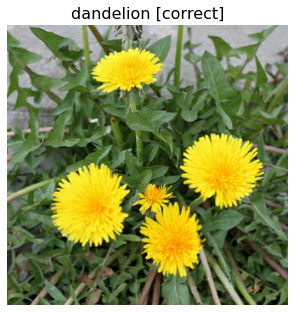

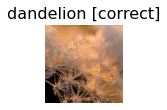

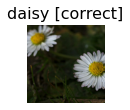

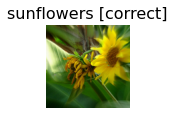

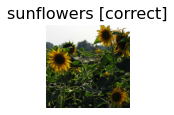

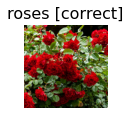

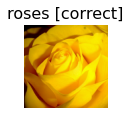

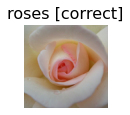

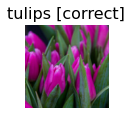

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)

# Utility

Colab automatically disconnect after 30 minutes idle. To stop this: F12 to open Chrome DevTools and add the following JavaScript snippet in the console. This makes a click on the connect-button every 60 seconds. Thus, Colab thinks that the notebook is not idle!



In [ ]:
# function KeepClicking(){
# console.log("Clicking");
# document.querySelector("colab-connect-button").click()
# }
# setInterval(KeepClicking,60000)